<a href="https://colab.research.google.com/github/john-fee/Opinion-Mining-with-Southpark/blob/master/Opinion_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opinion Mining with Southpark

## Motivation

The internet is a hive of social network activity - people on various social media platforms constantly message, share, and post to communicate with each other.  Given the sheer quantity of these communications, it's nigh impossible to gain an understanding of what they are collectively doing.  By using Natural Language Processing, a field concerned with computational understanding of language, we can transform online communications into mathematically useful forms from which useful information can be extracted.

We illustrate these techniques on the collection of scripts for the popular adult animated sitcom South Park.  By using a body of text, or corpus, that is familiar, we can leverage our "domain knowledge" to better assess the output of various NLP techniques.

## Data Preparation

As a first step, we have to collect the scripts for Southpark.  A kind Github user has already collected the first 19 seasons [here](https://github.com/BobAdamsEE/SouthParkData).

In [0]:
# Load libraries
import pandas as pd
idx = pd.IndexSlice

In [0]:
# Scrape data
def get_southpark_data(seasons_to_scrape = [x for x in range(1,20)]):
  ###
  ### Gets South Park script by season from github repository.  Only has data up through season 19.
  ###
  
  season_data_list = []
  for season_number in seasons_to_scrape:
    url = "https://raw.githubusercontent.com/BobAdamsEE/SouthParkData/master/by-season/Season-{}.csv".format(season_number)
    season_df = pd.read_csv(url)
    season_df["Episode"] = str(season_number) + "-" + season_df["Episode"].astype(str)
    season_data_list.append(season_df)
  southpark_data = pd.concat(season_data_list)
  southpark_data.reset_index(drop = True,inplace = True)
  southpark_data.set_index(["Season","Episode","Character"],inplace = True)
  return southpark_data    

southpark_data_all = get_southpark_data()

In [0]:
# View the first and last few entries of South Park data
southpark_data_all.head()


Line
Season Episode Character                                                   
1      1-1     Boys        School day, school day, teacher's golden ru...\n
               Kyle       Ah, damn it! My little brother's trying to fol...
               Ike                                           Zeeponanner.\n
               Kyle               Ike, you can't come to school with me. \n
               Cartman                    Yeah, go home you little dildo.\n

In [0]:
southpark_data_all.tail()

Line
Season Episode Character                                                      
19     19-10   Randy         Why did it have to be like this?! Why couldn't...
               Sharon                Randy, you're yelling at a Whole Foods.\n
               Randy         Go on, get outta here! We know! Others will kn...
               PC Principal  Alright everyone, listen up. I don't know abou...
               Stan                         This is going to be really hard.\n

Note that there are some artifacts in the data source (the "\n"s).  We're going to want to remove these and perform a few other manipulations to make the text more tractable.  To do that, we're going to have to introduce some concepts.

### Tokens

Tokens are sequences of a characters which are deemed to be a single semantic unit.  These can be single words, but depending on the NLP task could be multiple words (word phrases) or transformed words.  See [here](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) for a further discussion of tokens.

### Lemmas and Stemming

Often when working with text, we want to map related words to a single representation (e.g. cats and cat to cat).  A lemma is the base form of a token derived from morphological (structural) analysis, while a stemmed word is a base form of a token derived through heuristic "shortening" rules. See [here](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) for examples.

### Collocations

Collocations are combinations of words that occur more frequently than one would expect by chance ([wikipedia](https://en.wikipedia.org/wiki/Collocation)).  This can be used to identify word phrases (e.g. New York), but the idea of collocation underlies much of NLP.

In [0]:
# Install libraries
!pip install gensim

# Load libraries
from gensim.parsing.preprocessing import preprocess_string
from gensim.models.phrases import Phrases, Phraser

    100% |████████████████████████████████| 23.5MB 1.3MB/s 
    100% |████████████████████████████████| 1.4MB 12.8MB/s 
    100% |████████████████████████████████| 133kB 23.8MB/s 
    100% |████████████████████████████████| 61kB 17.2MB/s 
    100% |████████████████████████████████| 4.5MB 5.5MB/s 
    100% |████████████████████████████████| 552kB 21.3MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /content/.cache/pip/wheels/73/f1/9b/ccf93d4ba073b6f79b1ed9df68ab5ce048d8136d0efcf90b30
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /content/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
# Clean text
class corpus_generator(object):
  def __init__(self,data):
    self.data = data
    
    # Train phraser to identify word phrases
    phrases = Phrases((doc for doc in data))
    bigram = Phraser(phrases)
    phrases_bigram = Phrases(bigram[southpark_data_all["Line"]])
    trigram = Phraser(phrases_bigram)
    self.phrase_detector = trigram
    
  def __iter__(self):
    for doc in self.data:
      doc_cleaned = self._clean_text(doc)
      doc_with_phrases = self.phrase_detector[doc_cleaned]
      yield doc_with_phrases
      
  def _clean_text(self,text):
    text.replace("\n"," ") # Remove "\n" that occurs at the end of every string
    cleaned_text = preprocess_string(text)
    # Need phrase detection
    return cleaned_text
    

We've created a Python class which takes text, cleans it (makes everything lowercases, removes extraneous punctuation, etc), stems the tokens, and trains a phrase detector to join together any phrases that exist.  The cleaning process also removes "stop words", frequently occurring word which are deemed uniformative.

In [0]:
# Augment existing data with cleaned lines

southpark_data_all["Line_cleaned"] = [doc for doc in corpus_generator(southpark_data_all["Line"])]

In [0]:
southpark_data_all.head()

Line  \
Season Episode Character                                                      
1      1-1     Boys        School day, school day, teacher's golden ru...\n   
               Kyle       Ah, damn it! My little brother's trying to fol...   
               Ike                                           Zeeponanner.\n   
               Kyle               Ike, you can't come to school with me. \n   
               Cartman                    Yeah, go home you little dildo.\n   

                                                         Line_cleaned  
Season Episode Character                                               
1      1-1     Boys       [school, dai, school, dai, teacher, golden]  
               Kyle       [damn, littl, brother, try, follow, school]  
               Ike                                        [zeeponann]  
               Kyle                                [ik, come, school]  
               Cartman                     [yeah, home, littl, dildo]

In [0]:
southpark_data_all.tail()

Line  \
Season Episode Character                                                         
19     19-10   Randy         Why did it have to be like this?! Why couldn't...   
               Sharon                Randy, you're yelling at a Whole Foods.\n   
               Randy         Go on, get outta here! We know! Others will kn...   
               PC Principal  Alright everyone, listen up. I don't know abou...   
               Stan                         This is going to be really hard.\n   

                                                                  Line_cleaned  
Season Episode Character                                                        
19     19-10   Randy         [like, couldn, try, live, planet, mayb, perfec...  
               Sharon                                      [randi, yell, food]  
               Randy                [outta, know, know, isn, go, easi, anymor]  
               PC Principal  [alright, listen, know, sick, tire, hate, spee...  
               Stan                                                 [go, hard]

Note that our cleaned lines are now just lists of stemmed tokens (gensim uses a simple stemmer).  Note some of the problems with this - "outta" isn't recognized as "out of".

In [0]:
def document_merging(data,merge_by):
  results_dict = {}
  merge_by_index = data.index.names.index(merge_by)
  merge_by_levels = data.index.levels[merge_by_index]
  for level in merge_by_levels:
    if merge_by == "Season":
      data_subset = data.loc[idx[level,:,:],:]
    if merge_by == "Episode":
      data_subset = data.loc[idx[:,level,:],:]
    if merge_by == "Character":
      data_subset = data.loc[idx[:,:,level],:]
    new_doc = []
    for doc in data_subset["Line_cleaned"]:
      for token in doc:
        new_doc.append(token)
    results_dict["{}_{}".format(merge_by,level)] = new_doc
    
  return results_dict 

southpark_data_by_season = document_merging(southpark_data_all,"Season")
southpark_data_by_episode = document_merging(southpark_data_all,"Episode")
southpark_data_by_character = document_merging(southpark_data_all,"Character")

We also want to be able to group together our cleaned text by character, season, or episode.

## Word Importance


A common way to extract meaning from documents is to extract characteristic/important words.  Let's examine the characteristic words for the character "Cartman".  The simplest approach is to rank them by how frequently they are spoken.

In [0]:
# Sparse BoW
# Word frequencies
from gensim.corpora import Dictionary

def get_most_common_words(dictionary,corpus_subset,verbose = False):
  bag_of_words = dictionary.doc2bow(corpus_subset)
  named_words = [(dictionary[word_id],frequency) for (word_id,frequency) in bag_of_words]
  sorted_words = sorted(named_words,key = lambda x: x[1],reverse = True)
  if verbose:
    print("Number of unique words in the corpus subset: {}".format(len(dictionary)))
    print("Most common words and their frequency")
    for i in range(10):
      print(sorted_words[i])
  return sorted_words

# Treat the body of text belonging to each character as a separate document, then count the most frequent words for the Cartman document
dictionary = Dictionary(southpark_data_by_character.values())
most_important_words_frequency_Cartman = get_most_common_words(dictionary,southpark_data_by_character["Character_Cartman"],verbose = True)

Number of unique words in the corpus subset: 18585
Most common words and their frequency
('gui', 996)
('kyle', 922)
('right', 651)
('know', 611)
('gonna', 571)
('like', 563)
('yeah', 547)
('come', 536)
('butter', 508)
('dude', 451)


In [0]:
# Did any words actually end up being linked by phrase detection?
for word_id in dictionary:
  word = dictionary[word_id]
  if "_" in word:
    print(word)

Now,  let's try using term frequency, inverse document frequency (tf-idf) to extract keywords for Cartman.  This is a heuristic that reweights the importance of each word according to the formula

$$
weight = \text{term frequency} \times log_{2}(\frac{N}{\text{document frequency}})
$$

where *term frequency* is the number of times a word appears in a document (number of times Cartman speaks a word), *N* is the number of documents (characters), and *document frequency* is the number of documents (characters) that the word appears in.


This will de-emphasize words which are spoken by multiple characters.  To obtain the tf-idf weighting for words, we treat the entire body of lines spoken by each character as a single document.

Further reading on tf-idf and its variations can be found [here](http://mlwiki.org/index.php/TF-IDF#Good_Weighting_System)

In [0]:
# TF-IDF
# A reweighting of word frequency proportional to term frequency and inversely proportional to document frequency
from gensim.models import TfidfModel

def get_important_words_tfidf(dictionary,corpus,corpus_subset,verbose = False):
  # Corpus is needed to train tfidf model
  # Corpus subset is a single document/character's lines
  corpus_bag_of_words = (dictionary.doc2bow(doc) for doc in corpus) # Transforms corpus to bag of words representation
  corpus_subset_bag_of_words = dictionary.doc2bow(corpus_subset)
  model = TfidfModel(corpus_bag_of_words)  # Creates tf-idf weights
  corpus_subset_tfidf = model[corpus_subset_bag_of_words]
  named_words = [(dictionary[word_id],weight) for (word_id,weight) in corpus_subset_tfidf] # Convert from word ids to word names
  sorted_words = sorted(named_words,key = lambda x: x[1],reverse = True)
  if verbose:
    print("Most important words by tf-idf weighting")
    for i in range(10):
      print(sorted_words[i])
  return sorted_words
  
most_important_words_tfidf_Cartman = get_important_words_tfidf(dictionary,southpark_data_by_character.values(),southpark_data_by_character["Character_Cartman"],verbose = True)


Most important words by tf-idf weighting
('kyle', 0.390034680302628)
('gui', 0.29489397402269485)
('butter', 0.22968512678005118)
('dude', 0.20451170221263418)
('kenni', 0.17730393695152988)
('mom', 0.15590453095110032)
('gonna', 0.14538652819360492)
('know', 0.12901111954463151)
('right', 0.12712128220446686)
('yeah', 0.1190040156337816)


In [0]:
import numpy as np
class contextual_salience_model(object):
  def __init__(self,corpus_vectorized):
    # corpus needs to be in matrix form or we need to transform it here
    self.corpus_vectorized = corpus_vectorized
  
  def __iter__(self):
    # Go through corpus and apply contextual salience algorithm
    # Need to implement
    # ALSO NEED TO MAKE SURE DIMENSIONS LINE UP
    S_corpus = None
    
    for doc in self.corpus_vectorized:
      S_doc = None
      yield self._contextual_salience(doc,S_doc,S_corpus)

  def _contextual_salience(self,vector,S_doc,S_corpus):
    ###
    ### vector is a px1 vector representation of the document
    ### S_doc is the covariance of the vector representations of the document (pxp)
    ### S_corpus is the covariance of the vector representations of the corpus (pxp)
    ###
    S_doc_weighted = S_doc
    S_corpus_weighted = S_corpus
    return np.sqrt(vector.transpose() @ np.multiply(S_doc_weighted,S_corpus_weighted) @ vector)  


def get_important_words(vector,doc,corpus):
  corpus_bag_of_words = (dictionary.doc2bow(doc) for doc in corpus) # Transforms corpus to bag of words representation


How do a character's characteristic keywords change from season to season?

<class 'pandas.core.series.Series'>
0     NaN
2     NaN
4     NaN
6      12
8       8
10     44
12     40
14     39
16     42
18     26
Name: butter, dtype: object
<class 'pandas.core.series.Series'>
0     NaN
2     NaN
4     NaN
6     NaN
8       4
10    NaN
12    NaN
14    NaN
16    NaN
18    NaN
Name: david, dtype: object
<class 'pandas.core.series.Series'>
0     15
2     22
4     24
6     22
8     19
10    12
12    13
14    18
16    14
18    13
Name: dude, dtype: object
<class 'pandas.core.series.Series'>
0     51
2     85
4     99
6     92
8     63
10    71
12    71
14    39
16    29
18    78
Name: gui, dtype: object
<class 'pandas.core.series.Series'>
0     33
2      8
4     15
6     34
8     37
10    39
12    96
14    59
16    33
18    81
Name: kyle, dtype: object
<class 'pandas.core.series.Series'>
0     10
2     16
4     32
6     33
8     20
10    33
12    33
14    16
16    15
18    27
Name: okai, dtype: object
<class 'pandas.core.series.Series'>
0     12
2      6
4     15
6  

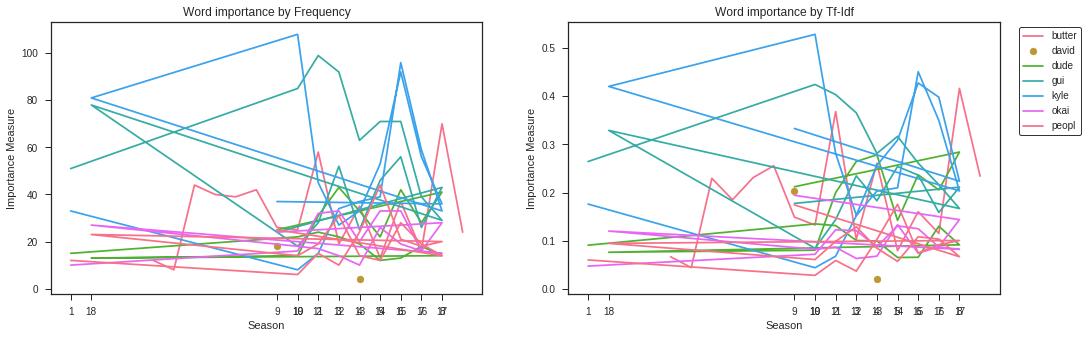

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import OrderedDict

# Control graph defaults
sns.set_style("ticks")

def get_word_importance_data(character,data):
  # Get seasons to compare from data
  season_multindex = data.index.names.index("Season")
  seasons_to_compare = data.index.levels[season_multindex]
  
  # Get vocab to initialize results dataframe
  all_season_vocabulary = [word for word in Dictionary(data["Line_cleaned"]).values()]
  results_df = pd.DataFrame(columns = ["Season","Method"] + all_season_vocabulary)
  top_5_common_words = set()
  top_5_important_words_tfidf = set()
  
  for season_number in seasons_to_compare:
    # Get dictionary for season
    season_subset = data.loc[idx[season_number,:,:],:]
    data_by_character = document_merging(season_subset,"Character")
    dictionary = Dictionary(data_by_character.values())
    
    # Get most common words
    most_common_words = get_most_common_words(dictionary,data_by_character[character])
    words_to_add = set([tup[0] for tup in most_common_words[0:5]])
    top_5_frequency = top_5_common_words.union(words_to_add)
    
    temp_df = pd.DataFrame(dict(most_common_words),index = [0])
    temp_df["Season"] = season_number
    temp_df["Method"] = "Frequency"
    results_df = results_df.append(temp_df)
    
    # Get most important words via tf-idf
    most_important_words_tfidf = get_important_words_tfidf(dictionary,data_by_character.values(),data_by_character[character])
    words_to_add = set([tup[0] for tup in most_important_words_tfidf[0:5]])
    top_5_tfidf = top_5_important_words_tfidf.union(words_to_add)
    
    temp_df = pd.DataFrame(dict(most_important_words_tfidf),index = [0])
    temp_df["Season"] = season_number
    temp_df["Method"] = "Tf-Idf"
    results_df = results_df.append(temp_df)
    
    # More word importance measures go here if we want to expand
    
    # Set all 0 indices to proper order
    results_df.reset_index(drop = True,inplace = True)

  return results_df,list(top_5_frequency),list(top_5_tfidf)

def make_word_importance_graphs(character,data):
  results_df,top_5_frequency,top_5_tfidf = get_word_importance_data(character,data)
  graph_df = results_df.loc[:,["Season", "Method"] + list(set(top_5_frequency + top_5_tfidf))] # Select columns with only relevant words
  
  words_to_graph = sorted(list(set(top_5_frequency + top_5_tfidf)))
  seasons = list(graph_df["Season"].unique())
  fig,axes = plt.subplots(1,2,figsize = (17,5))
  
 
  
  # Word importance for each method
  methods_to_plot = list(graph_df["Method"].unique())
  for axis,method in zip(fig.axes,methods_to_plot):
    my_palette = itertools.cycle(sns.color_palette("husl")) # graph wasn't properly cycling through colors
    row_mask = graph_df["Method"] == method
    x = graph_df.loc[row_mask,["Season"]]
    
    # Plot importance for each word
    for word in words_to_graph:
      y = graph_df.loc[row_mask,word]
      print(type(y))
      print(y[0:10])
      line_color = next(my_palette)
      
      axis.plot(x,y,label = word,color = line_color)
      
      # Words that only appear for a few seasons don't show up as lines
      
      fraction_missing = y.isnull().sum()/len(y)
      if fraction_missing > 0.5:
        axis.scatter(x,y,label = word, color = line_color)

    # Format graph
    axis.set_title("Word importance by {}".format(method))
    axis.set_xlabel("Season")
    axis.set_xticks(seasons)
    axis.set_ylabel("Importance Measure")

  # Other graph formatting
  
  handles, labels = axis.get_legend_handles_labels()
  by_label = OrderedDict(zip(labels, handles))
  leg = axis.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.2,1), loc="upper right",frameon = True,edgecolor = "black")
  leg.get_frame().set_linewidth(1)
  plt.show()

make_word_importance_graphs("Character_Cartman",southpark_data_all)

Note that both word importance measures measure similar relationships between important words for Cartman.  Given that we filtered out "stop words", this indicates that Cartman's most frequent words aren't (often) shared by other members of the Southpark cast.

In [0]:
results_df,top_5_frequency,top_5_tfidf = get_word_importance_data("Character_Cartman",southpark_data_all)

In [0]:
graph_df = results_df.loc[:,["Season", "Method"] + list(set(top_5_frequency + top_5_tfidf))] 

In [0]:
graph_df

,Season,Method,butter,david,peopl,kyle,okai,dude,gui
0,1,Frequency,NaN,NaN,12,33,10,15,51
1,1,Tf-Idf,NaN,NaN,0.0606285,0.176473,0.0479283,0.0912594,0.264634
2,2,Frequency,NaN,NaN,6,8,16,22,85
3,2,Tf-Idf,NaN,NaN,0.0286821,0.0444961,0.072408,0.135375,0.424356
4,3,Frequency,NaN,NaN,15,15,32,24,99
5,3,Tf-Idf,NaN,NaN,0.0595559,0.0684365,0.122971,0.131856,0.403355
6,4,Frequency,12,NaN,10,34,33,22,92
7,4,Tf-Idf,0.0672631,NaN,0.0374052,0.152408,0.121505,0.100996,0.365562
8,5,Frequency,8,4,24,37,20,19,63
9,5,Tf-Idf,0.0448041,0.0216664,0.103315,0.203646,0.0876461,0.100006,0.281419


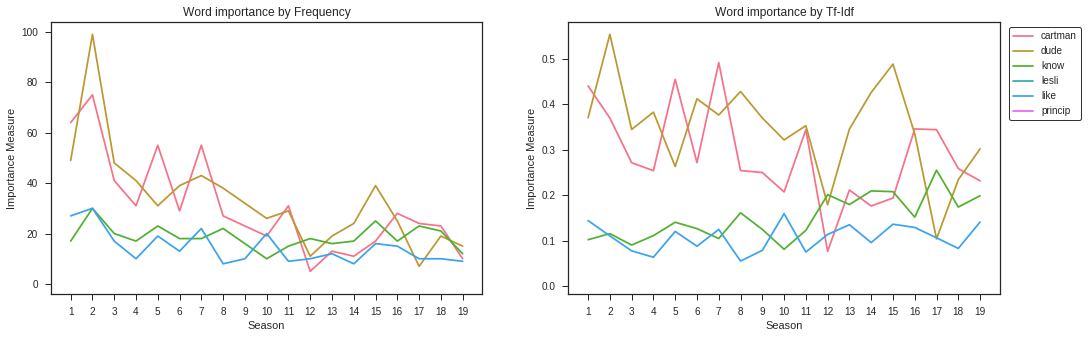

In [0]:
make_word_importance_graphs("Character_Kyle",southpark_data_all)

## Word and Sentence Representation

To model language, we have to make a series of choices on how to represent words, their relationship with each other, and the relationship between larger entities such as sentences.  How can we mathematically represent the lines spoken by each character?  

### Representing Words

**Lemmatization/Stemming**

Words previously known to have similar meaning are mapped to a single representation.

**Word Importance Measures**

Considerations other than the frequency of a word.


### Representing groups of words

The dominant modeling paradigm are Vector Space Models (VSM) - models which represent language in a vectorized semantic space.

**Bag of Words**

The simplest (but often effective) representation is the Bag of Words (BoW) format.  Word frequencies for the unit of interest (sentence, paragraph, document, etc) are computed and a transformation may be applied (such as tf-idf) to better measure the contribution of each word.  Information conveyed by the order of words is lost.

**Bag of N-grams**

The same as BoW, but the frequency of continuous sequences of tokens is considered instead of single words.  A 2-gram representation of "The cat ran quickly" would become \["The cat"."cat ran","ran quickly"\].  This captures more syntactic structure than BoW, but has computational limitations and cannot capture long term dependency.

**Dense Word Embeddings**

Approaches such as Latent Semantic Indexing (LSI) and newer neural language approaches such as Word2Vec, Doc2Vec, etc project words into a low dimensional space where similar words (according to some measure of similarity) are close to each other.  This contrasts with the "Bag of X" approaches, which are *sparse* representations of language.

Word embeddings can be combined (summed, averaged, multiplied, weighted by word importance and then combined) to produce dense representations for groups of words.  Groups of words can also be explicitly modeled with embeddings techniques such as Doc2Vec.




**With embeddings**



That being said, let's try finding words which are similar to Cartman using some of the above techniques.

**Note:** Investigate PMI, smoothing/regularization can be done to improve results

[article](https://multithreaded.stitchfix.com/blog/2017/10/18/stop-using-word2vec/) on effectiveness of this method vs word2vec

In [0]:
# Word2Vec
from gensim.models import Word2Vec

model_w2v = Word2Vec(southpark_data_all["Line_cleaned"],size = 300,iter = 1000)

In [0]:
model_w2v.wv.most_similar(positive = ["cartman"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('kyle', 0.4484092593193054),
 ('stan', 0.3477453589439392),
 ('butter', 0.3470917046070099),
 ('kenni', 0.3389805555343628),
 ('gui', 0.3377819061279297),
 ('know', 0.3312566876411438),
 ('right', 0.3195687532424927),
 ('gonna', 0.3157714307308197),
 ('think', 0.30084460973739624),
 ('mom', 0.2997584342956543)]

In [0]:
# Cartman's signature line is "screw you guys"
model_w2v.wv.most_similar(positive=["screw","gui"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('yeah', 0.4831019341945648),
 ('dude', 0.4326745271682739),
 ('right', 0.38963818550109863),
 ('kyle', 0.38738688826560974),
 ('wanna', 0.3747573494911194),
 ('mean', 0.355117529630661),
 ('hei', 0.35001885890960693),
 ('know', 0.34601062536239624),
 ('gonna', 0.34437325596809387),
 ('think', 0.34096384048461914)]

We can find similar lines by combining the word vectors for individual words.

good recommendations for how to do so can be found [here](https://stackoverflow.com/questions/29760935/how-to-get-vector-for-a-sentence-from-the-word2vec-of-tokens-in-sentence)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

# Find similar lines by adding word vectors and computing cosine similarity
def create_w2v_corpus(w2v_model,corpus):
  w2v_dimension = w2v_model.trainables.layer1_size
  corpus_length = len(corpus)
  corpus_w2v = np.empty((corpus_length,w2v_dimension))
  
  for index,doc in enumerate(corpus):
    for token in doc:
      try:
        corpus_w2v[index,:] += w2v_model.wv.get_vector(token)
      except KeyError:
        pass
  return corpus_w2v

def get_similar_docs_w2v(words,corpus_w2v,model,corpus = southpark_data_all["Line_cleaned"],combination_method = "sum"):
  # Get word vectors for query
  word_vectors = []
  for word in words:
    try:
      word_vectors.append(model.wv.get_vector(word))
    except KeyError:
      pass
  
  # Combine word vectors 
  if combination_method == "sum":
    document_vector = sum(word_vectors)
  elif combination_method == "avg":
    document_vector = sum(word_vectors)/len(word_vectors)
  
  # Rank word vectors by cosine similarity
  similarity_matrix = cosine_similarity(np.reshape(document_vector,(1,-1)),corpus_w2v)[0]
  sort_index = np.argsort(-similarity_matrix) # np.argsort sorts in ascending

  # Print top 10 similar lines (uncleaned)
  similar_docs = southpark_data_all.iloc[sort_index[0:10],list(southpark_data_all.columns).index("Line")]
  scores = similarity_matrix[sort_index[0:10]]
  for i,(doc,similarity_score) in enumerate(zip(similar_docs,scores)):
    print("Similarity: {}".format(similarity_score))
    print(doc)
  return zip(similar_docs,scores)

In [0]:
words = ["screw","gui"]
corpus_w2v = create_w2v_corpus(model_w2v,southpark_data_all["Line_cleaned"])
similar_docs_w2v = get_similar_docs_w2v(words,corpus_w2v,model_w2v)

Similarity: 0.9999999999999998
Lehh, eh, screw you guys!

Similarity: 0.9999999999999998
Blulululuh. Screw you guys.

Similarity: 0.9999999999999998
Screw you guys, screw you guysScrew you guys, scr--

Similarity: 0.9999999999999998
Well, screw you guys! 

Similarity: 0.9319565646236079
Screw that, dude! We're guys. We can outthink them.

Similarity: 0.9244372341953893
Ye-ah, screw those guys. I don't even like them.

Similarity: 0.8911322325148294
Yeah, screw them!

Similarity: 0.8783150790502321
Screw you guys! … Go to Hell!

Similarity: 0.8769994729002588
Screw this guy! He can't take out all of us!  Aargh!

Similarity: 0.8768901763446146
Hey! Don't screw around! You screw around too much!



Directly embedding documents using Doc2Vec can also allow us to identify similar lines.

In [0]:
# Doc2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
class tagged_doc_generator(object):
  def __init__(self,data = southpark_data_all["Line_cleaned"]):
    self.data = data
  
  def __iter__(self):
    for index,doc in enumerate(self.data):
      yield TaggedDocument(words = doc,tags = [index])

class doc2vec_class(object):
  def __init__(self,vector_size = 100,epochs = 1000,doc_generator = tagged_doc_generator()):
    self.vector_size = vector_size
    self.epochs = epochs
    self.doc_generator = doc_generator
    
    self.model = Doc2Vec(self.doc_generator,self.vector_size,self.epochs)
    
  def get_most_similar_docs(self,words):
    new_vector = self.model.infer_vector(words)
    similar_documents = self.model.docvecs.most_similar([new_vector])
    for tup in similar_documents:
      print("Similarity: {}".format(tup[1]))
      print(southpark_data_all.iloc[tup[0],southpark_data_all.columns.get_loc("Line")])
    
model_d2v = doc2vec_class()

In [0]:
words = ["screw","gui"]
model_d2v.get_most_similar_docs(words)

Similarity: 0.8231909275054932
Goddammit, vegans piss me off! Now we're gonna end up with a stupid eagle or a faggy bobcat as a mascot.

Similarity: 0.8221637010574341
YEAH!  Free Hat! Free Hat! Free Hat! Free Hat! Free Hat! Free Hat! Free Hat! Free Hat!

Similarity: 0.8214345574378967
Yeah. You know, I had a guy in Jackson County. He had a little drum circle in his backyard. It turned into a drum circle four miles in diameter. You get a few hippies playing drums and next thing you know, you got yourself a colony.

Similarity: 0.8207608461380005
FOX Studios claims that the Family Guy writing staff has demanded the Mohammad character be seen in full view.  The head of FOX had this to say:

Similarity: 0.8171677589416504
Tootin' tootin' to, tada choo choo wow!
There's a place called the rainforest; it truly sucks ass.
Let's knock it all down and get rid of it fast.
You say, "Save the rainforest," but what do you know?
You've never been to the rainforest before.
Getting Gay With Kids is h

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Some other word embedding resources include a [paper](https://openreview.net/pdf?id=SyK00v5xx) on how to achieve strong baseline performance, and [poincare embeddings](https://arxiv.org/pdf/1705.08039.pdf).



Embeds words into a low dimensional space using Singular Value Decomposition.  This could allow us to perform similarity queries, but in addition it allows us to infer topics for a document!

In [0]:
# Latent Semantic Indexing/Analysis (LSI/LSA)
from gensim.models import LsiModel

class lsi_class(object):
  
  def __init__(self,data,dictionary = None):
    self.data = data
    self.dictionary = dictionary
    if not dictionary:
      self.dictionary = Dictionary(self.data)
      
    # Transform data into tf-idf representation
    self.data_transformed = [dictionary.doc2bow(doc) for doc in self.data] # bow representation
    tfidf_model = TfidfModel(self.data_transformed)  # Creates tf-idf weights
    self.data_transformed = tfidf_model[self.data_transformed] # Transforms bow representation
    
    # Train model
    lsi_model = LsiModel(self.data_transformed,num_topics = 300, id2word = dictionary)
    self.model = lsi_model
    
  def get_most_similar_words(self,word):
    pass
  
  def get_topics(self,doc):
    pass


model_lsi = LsiModel([dictionary.doc2bow(doc) for doc in southpark_data_all["Line_cleaned"]],num_topics = 300,id2word = dictionary)

In [0]:
test = lsi_class(southpark_data_all["Line_cleaned"],dictionary = dictionary)

In [0]:
test.model.print_topics(num_topics=10,num_words=5)

[(0,
  '0.991*"yeah" + 0.071*"right" + 0.040*"know" + 0.034*"dude" + 0.028*"come"'),
 (1,
  '0.607*"right" + 0.289*"know" + 0.261*"dude" + 0.245*"come" + 0.215*"hei"'),
 (2,
  '-0.763*"right" + 0.374*"dude" + 0.275*"know" + 0.243*"hei" + 0.138*"okai"'),
 (3,
  '0.719*"ye" + -0.541*"dude" + 0.369*"know" + -0.153*"hei" + -0.094*"right"'),
 (4,
  '-0.666*"ye" + -0.525*"dude" + 0.446*"know" + 0.196*"okai" + 0.142*"god"'),
 (5,
  '0.627*"know" + -0.521*"god" + -0.342*"okai" + 0.302*"dude" + -0.203*"hei"'),
 (6,
  '0.759*"god" + -0.550*"okai" + -0.190*"hei" + 0.155*"know" + 0.127*"dude"'),
 (7,
  '0.643*"hei" + -0.619*"okai" + -0.292*"dude" + 0.207*"gui" + -0.182*"god"'),
 (8,
  '0.803*"come" + -0.463*"hei" + -0.237*"okai" + 0.159*"let" + -0.109*"god"'),
 (9,
  '0.989*"huh" + -0.096*"come" + -0.055*"hei" + -0.051*"know" + -0.042*"god"')]

## Topic Modeling

[This](https://blog.insightdatascience.com/topic-modeling-and-sentiment-analysis-to-pinpoint-the-perfect-doctor-6a8fdd4a3904) post might be useful

[Paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.163.5917&rep=rep1&type=pdf) on joint topic-sentiment modeling

In [0]:
# Latent Dirichlet Allocation (LDA)

## Predicting Character Lines

We've examined different ways to represent lines in Southpark, let's see if we can determine the authorship of a given line.

In [0]:
# Convert bag of words representation to matrix with gensim, then to scipy sparse format

The code below features the Contextual Salience algorithm, a new approach on existing word importance measures which takes context into account.

[arixv](https://arxiv.org/pdf/1803.08493.pdf)